Preamble: these imports are needed for this notebook to work

In [69]:
import numpy as np

# Wipe all outputs from this notebook
from IPython.display import Image, clear_output, display
clear_output(True)

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline

# Add the course directory to the Python path
import sys
sys.path.append('../') 
import cphy.plotting as cplot


# The Game of Life and Cellular Automata

+ Cellular automata are systems where all physical laws and fields are discretized: space is a lattice, and time is discrete
+ Physical laws take the form of IF-THEN statements
+ Basic cellular automata are Markovian: given current field values at some set of lattice points, perform an instantaneous update based on a set of rules


## The Game of Life

+ Conway, 1970
+ Complex dynamics emerge from simple rules
+ Markovian: next state of universe depends only on current state of universe
+ Local: next state at a lattice point depends only on current site and nearest neighbors
+ Synchronous: we update all sites at once, rather than raster scanning
+ Finite fields: A site can have values of 1 (alive) or 0 (dead)

#### Game life rules:
1. Underpopulation: Any live cell with fewer than two live neighbours dies
2. Survival: Any live cell with two or three live neighbours lives stays alive
3. Overpopulation: Any live cell with more than three live neighbours dies
3. Reproduction: Any dead cell with *exactly* three live neighbours becomes a live cell

These simple rules give rise to surprisingly complex behaviors; in fact, the Game of Life has been shown to support universal computation, given a suitable encoding scheme based on initial conditions. We've included some examples of fixed-point, limit-cycle, and soliton like dynamics below


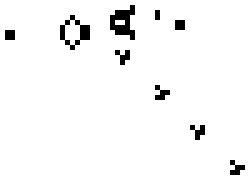

In [70]:
Image("../resources/Gospers_glider_gun.gif")
# Source: Scholarpedia

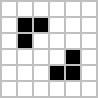

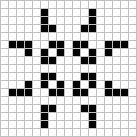

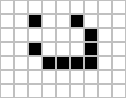

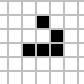

In [71]:
## Example solutions to the Game of Life

display(Image("../resources/Game_of_life_beacon.gif"))
display(Image("../resources/Game_of_life_pulsar.gif"))
display(Image("../resources/Game_of_life_animated_LWSS.gif"))
display(Image("../resources/Game_of_life_animated_glider.gif"))
# Source: Scholarpedia

# Game of Life implementation

In [72]:
# A base allows us to impose structure on specific cases. We will use this as a parent
# for subsequent classes
class CellularAutomaton:
    """
    A base class for cellular automata. Subclasses must implement the step method.

    Parameters
        n (int): The number of cells in the system
        n_states (int): The number of states in the system
        random_state (None or int): The seed for the random number generator. If None,
            the random number generator is not seeded.
        initial_state (None or array): The initial state of the system. If None, a 
            random initial state is used.
        
    """
    def __init__(self, n, n_states, random_state=None, initial_state=None):
        self.n_states = n_states
        self.n = n
        self.random_state = random_state

        np.random.seed(random_state)

        ## The universe is a 2D array of integers
        if initial_state is None:
            self.initial_state = np.random.choice(self.n_states, size=(self.n, self.n))
        else:
            self.initial_state = initial_state
        self.state = self.initial_state

        self.history = [self.state]

    def next_state(self):
        """
        Output the next state of the entire board
        """
        return NotImplementedError

    def simulate(self, n_steps):
        """
        Iterate the dynamics for n_steps, and return the results as an array
        """
        for i in range(n_steps):
            self.state = self.next_state()
            self.history.append(self.state)
        return self.state



class ExtinctionAutomaton(CellularAutomaton):
    """
    A cellular automaton that simulates the extinction of a species.
    """
    def __init__(self, n, **kwargs):
        super().__init__(n, 2, **kwargs)

    def next_state(self):
        """
        Output the next state of the entire board
        """
        next_state = np.zeros_like(self.state)
        return next_state


class RandomAutomaton(CellularAutomaton):
    """
    A cellular automaton with random updates
    """
    def __init__(self, n, random_state=None, **kwargs):
        super().__init__(n, 2, **kwargs)
        self.random_state = random_state

    def next_state(self):
        """
        Output the next state of the entire board
        """
        next_state = np.random.choice(self.n_states, size=(self.n, self.n))
        return next_state

Text(0.5, 1.0, 'Final state')

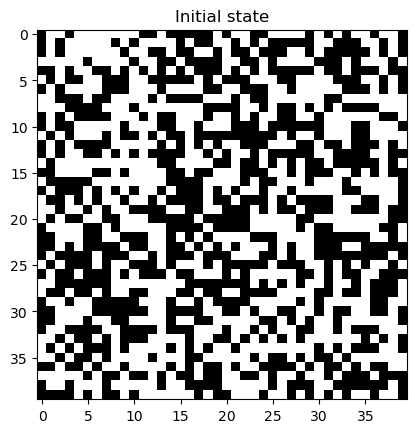

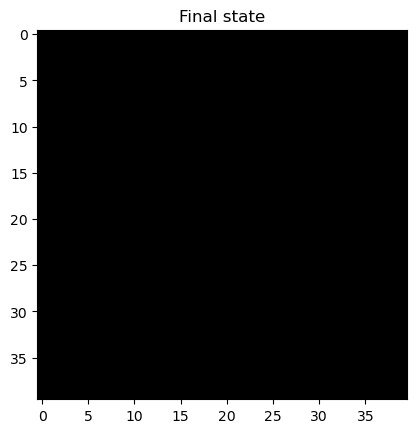

In [73]:
model = ExtinctionAutomaton(40, random_state=0)
model.simulate(200)

plt.figure()
plt.imshow(model.initial_state, cmap="gray")
plt.title("Initial state")

plt.figure()
plt.imshow(model.state, cmap="gray")
plt.title("Final state")

Text(0.5, 1.0, 'Final state')

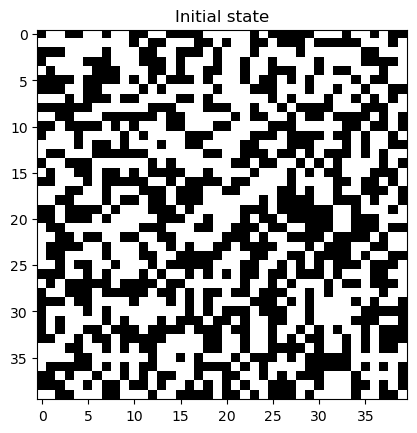

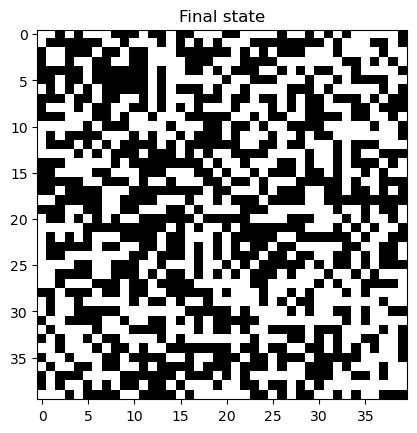

In [74]:
model = RandomAutomaton(40, random_state=0)
model.simulate(200)

plt.figure()
plt.imshow(model.initial_state, cmap="gray")
plt.title("Initial state")

plt.figure()
plt.imshow(model.state, cmap="gray")
plt.title("Final state")

In [75]:
        
# This child class inherits methods from the parent class
class GameOfLife(CellularAutomaton):
    """
    An implementation of Conway's Game of Life in Python

    Args:
        n (int): The number of cells in the system
        **kwargs: Additional keyword arguments passed to the base CellularAutomaton class
    """

    def __init__(self, n, **kwargs):
        # the super method calls the parent class's __init__ method
        # and passes the arguments to it. It is a constructor 
        super().__init__(n, 2, **kwargs)

    def next_state(self):
        """
        Compute the next state of the lattice
        """
        # Compute the next state
        next_state = np.zeros_like(self.state)
        for i in range(self.n):
            for j in range(self.n):
                
                # Compute the number of neighbors
                n_neighbors = np.sum(
                    self.state[i - 1:i + 2, j - 1:j + 2]
                ) - self.state[i, j]
                
                # Update the next state
                if self.state[i, j] == 1:
                    if n_neighbors in [2, 3]:
                        next_state[i, j] = 1
                else:
                    if n_neighbors == 3:
                        next_state[i, j] = 1
        return next_state

Average time per iteration: 3.48 ms ± 20.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Text(0.5, 1.0, 'Final state')

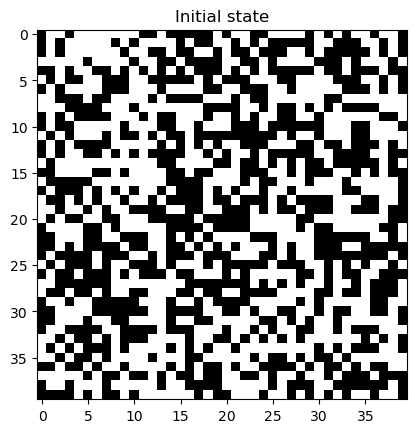

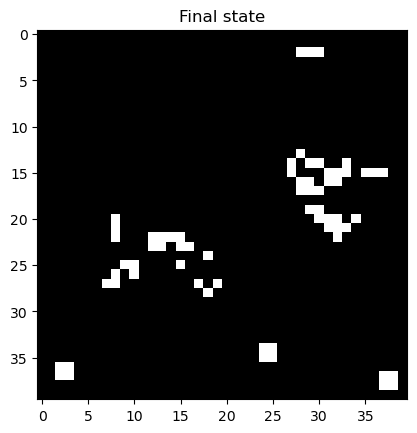

In [76]:
model = GameOfLife(40, random_state=0)
model.simulate(200)

# print timing results
print("Average time per iteration: ", end="")
%timeit model.next_state()

plt.figure()
plt.imshow(model.initial_state, cmap="gray")
plt.title("Initial state")

plt.figure()
plt.imshow(model.state, cmap="gray")
plt.title("Final state")

In [77]:
## Make an interactive video
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

def plotter(i):
    # plt.close()
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(model.history[i], vmin=0, vmax=1, cmap="gray")
    plt.show()

interact(
    plotter, 
    i=widgets.IntSlider(0, 0, len(model.history) - 1, 1, layout=Layout(width='800px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='800px'), max=200), Output()), _…

<function __main__.plotter(i)>

## How can we improve our implementation?

A key idea of cellular automata is *locality*: the update of each site depends only on the state of its neighbors. The Game of Life uses a *Moore* neighborhood, in which the first nearest neighbors (including diagonals) are considered. The Game of Life update rule can therefore be seen as first implementing convolution of the grid state $f$ with a kernel $g$ of the form

$$
g \equiv
\begin{bmatrix}
1 & 1 & 1 \\
1 & 0 & 1 \\
1 & 1 & 1
\end{bmatrix}
$$

This discrete convolution essentially takes the sum of the neighbors, and uses this sum plus the state of the center cell in order to decide what to do. This makes the Game of Life an example of an *outer totalistic* cellular automaton. Recall that a two-dimensional discrete convolution has the form

$$
(f * g)(x, y) = \sum_{m=-\infty}^{\infty} \sum_{n=-\infty}^{\infty} f(x-m, y-n) g(m, n)
$$

However, when the kernel has compact support (as in our nearest-neighborhood update rule), this double summation simplifies,

$$
(f * g)(x, y) = \sum_{m=-K}^{K} \sum_{n=-K}^{K} f(x-m, y-n) g(m, n)
$$

For our Game of Life example, $K=1$. The periodic boundary conditions can be implemented by padding each dimension of $f$ with values from the other side of the array, and then cropping the convolution result to the original size of $f$. We can estimate the number of multiplications required to perform a discrete convolution by counting the number of elements in the kernel, $M$, and the number of elements in the grid, $N$, for an overall time complexity of $\mathcal{O}(M\,N)$.

In [78]:

from scipy.signal import convolve2d

class GameOfLife(CellularAutomaton):

    def __init__(self, n, **kwargs):
        # the super method calls the parent class's __init__ method
        # and passes the arguments to it. It is a constructor 
        super().__init__(n, 2, **kwargs)

    def next_state(self):
        """
        Compute the next state of the lattice using discrete convolutions to implement
        the rules of the Game of Life.
        """
        # Compute the next state
        next_state = np.zeros_like(self.state)

        # Compute the number of neighbors for each cell
        totalistic_kernel = np.ones((3, 3))
        totalistic_kernel[1, 1] = 0 # don't count the center cell itself
        
        # convolve with periodic boundary conditions
        n_neighbors = convolve2d(self.state, totalistic_kernel, mode='same', boundary='wrap')


        next_state = np.logical_or(
            np.logical_and(self.state == 1, n_neighbors == 2),
            n_neighbors == 3
        )

        return next_state

model = GameOfLife(40, random_state=0)
model.simulate(200)

print("Average time per iteration: ", end="")
%timeit model.next_state()

plt.figure()
plt.imshow(model.initial_state, cmap="gray")
plt.title("Initial state")

plt.figure()
plt.imshow(model.state, cmap="gray")
plt.title("Final state")

KeyboardInterrupt: 

### Can we go even faster?

Based on the discrete convolution equation, we estimate that the runtime of a single update step is proportional to both the Moore neighborhood size and the total size of the grid, $\mathcal{O}(M\,N)$. Because the update rule is local, however, $M/N \ll 1$ and so the runtime is dominated by the factor $\mathcal{O}(N)$.

It turns out that we can speed up the convolution operation significantly. Recall the equivalence between convolution and multiplication in the Fourier domain:

$$
\mathcal{F}\{f * g\} = \mathcal{F}\{f\} \cdot \mathcal{F}\{g\}
$$

where $\mathcal{F}$ is the Fourier transform operator. This means that we can compute the convolution of two functions by multiplying their Fourier transforms and then taking the inverse Fourier transform of the result. Since the product is taken elementwise over the transformed array and kernel, we expect the product to require $\mathcal{O}(N)$ multiplication operations, but we gain the cost of performing and inverting the Fourier transform. The Fourier Transform integral in two dimensions has the form

$$
\mathcal{F}\{f(x,y)\} = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} f(x,y) e^{-i\,k_x\,x} e^{-i\,k_y\,y} dx\,dy
$$

where $k_x$ and $k_y$ are the spatial frequencies in the $x$ and $y$ directions, respectively. Naively, this integral might appear to take $\mathcal{O}(N^2)$ operations to compute, but it turns out that we can compute the Fourier transform in $\mathcal{O}(N\,\log N)$ operations using the [Fast Fourier Transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform) algorithm.

# Extending the Game of Life to a continuous domain

+ We saw that the update rule for the game of life is a function of the number of neighbors of a cell.
+ We can replace the discrete neighbor kernel with a continuous one.
+ This basic idea is extended and refined in [Lenia](https://arxiv.org/abs/1812.05433), a fully continuous-time and continuous-space cellular automaton that exhibits surprisingly complex, life-like behavior.

In [110]:
from scipy.stats import multivariate_normal


def gaussian_kernel(size: int, sigma: float):
    kernel = np.fromfunction(
        lambda x, y: (1/ (2 * np.pi * sigma**2)) * 
                     np.exp(- ((x - (size - 1) / 2) ** 2 + (y - (size - 1) / 2) ** 2) / (2 * sigma**2)),
        (size, size)
    )
    return kernel / np.sum(kernel)

def soft_threshold(x, lower, upper):
    """
    Smoothly threshold an array to have values between the upper and lower bounds
    using logistic functions.
    """
    return -1 / (1 + np.exp(-10 * (x - upper))) - 1 / (1 + np.exp(-10 * (x - lower)))

class SmoothGameOfLife(CellularAutomaton):

    def __init__(self, n, r=1, **kwargs):
        # the super method calls the parent class's __init__ method
        # and passes the arguments to it. It is a constructor 
        super().__init__(n, 2, **kwargs)
        self.r = r

    def next_state(self):
        """
        Compute the next state of the lattice using discrete convolutions to implement
        the rules of the Game of Life.
        """
        # Compute the next state
        next_state = np.zeros_like(self.state)

        # Make a gaussian convolutional kernel of 10 x 10 size
        # with standard deviation 1
        neighbors_kernel = gaussian_kernel(10, self.r)
        self_kernel = gaussian_kernel(10, 0.25)
        totalistic_kernel = neighbors_kernel - self_kernel
        totalistic_kernel /= np.sum(totalistic_kernel)

        # convolve with periodic boundary conditions
        n_neighbors = convolve2d(self.state, totalistic_kernel, mode='same', boundary='wrap')

        # logistic threshold n_neighbors to exactly 3
        n_neighbors3 = soft_threshold(n_neighbors, 2.5, 3.5)
        # n_neighbors3 /= np.sum(n_neighbors3)

        # logistic threshold n_neighbors to above 2
        n_neighbors2 = soft_threshold(n_neighbors, 1.5, 2.5)
        # n_neighbors2 /= np.sum(n_neighbors2)

        next_state = soft_threshold(self.state * n_neighbors2 + n_neighbors3, 0, 2)
        # next_state /= np.sum(next_state)

        return next_state

/var/folders/xt/9wdl4pmx26gf_qytq8_d528c0000gq/T/ipykernel_48936/3762526830.py:17: RuntimeWarning: overflow encountered in exp
  return -1 / (1 + np.exp(-10 * (x - upper))) - 1 / (1 + np.exp(-10 * (x - lower)))


Average time per iteration: 282 µs ± 4.38 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Text(0.5, 1.0, 'Final state')

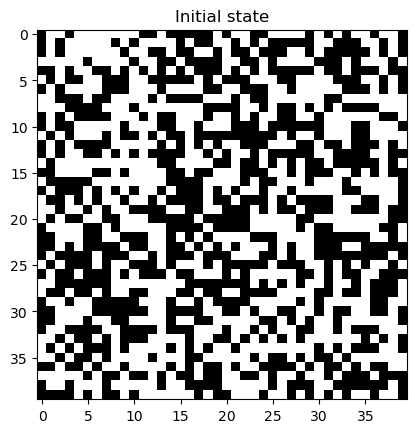

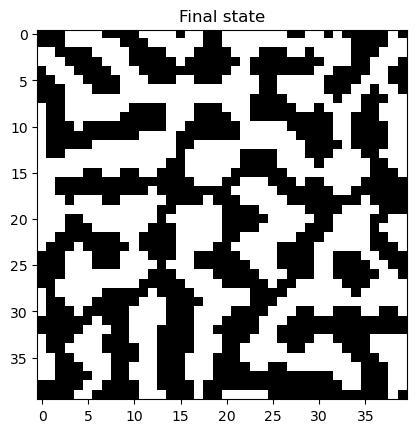

In [111]:
model = SmoothGameOfLife(40, 3, random_state=0)
model.simulate(200)

print("Average time per iteration: ", end="")
%timeit model.next_state()

plt.figure()
plt.imshow(model.initial_state, cmap="gray")
plt.title("Initial state")

plt.figure()
plt.imshow(model.state, cmap="gray")
plt.title("Final state")

In [112]:
## Make an interactive video
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

def plotter(i):
    # plt.close()
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(model.history[i], cmap="gray")
    plt.show()

interact(
    plotter, 
    i=widgets.IntSlider(0, 0, len(model.history) - 1, 1, layout=Layout(width='800px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='800px'), max=200), Output()), _…

<function __main__.plotter(i)>

# Cellular automata: additional context and information

+ Cellular automata represent an intriguing example of a physical system where surprising complexity emerges from relatively simple rules.
+ Cellular automata have a rich history in the physics literature, although their popularity has declined somewhat due to a lack of analytical tools for working with their governing equations. 
+ One common criticism of Game-of-Life like CAs comes from their requirement of a *synchronous* update rule: all of the cells update to a new state at the same time: the value of a cell $x_{ij}(t+1)$ depends on the "frozen" values $x_{ij}(t)$ and its neighbors at the same instant $t$. In a real-world system, updates are asynchronous: different cells will update at different times. One way of thinking about asynchronous updates is that we only update a single cell in a given timestep, and we gradually raster-scan across the entire image to update all cells sequentially. Asynchronous update rules usually have qualitatively distinct dynamics than synchronous CA.
+ In addition to having interesting theoretical properties, there are a few natural systems that exhibit discrete, local space and time dynamics that can be well described by CA equations. My favorite example is the [skin patterning of certain lizards](https://www.nature.com/articles/nature22031)

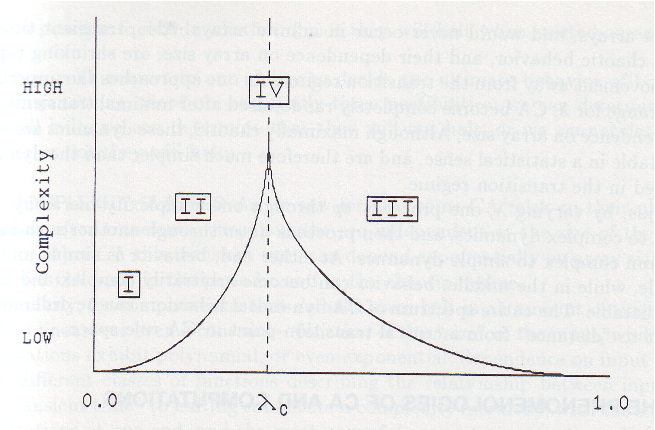

In [ ]:
Image("../resources/eoc_ce_lambda.png")
# Complexity of CA dynamics vs the entropy of the rule table
# Source: Langton 1990

# The size of the (discrete) universe

+ Scaling of memory with size and rules
+ Scaling of runtime with CA ruleset

### Memory Scaling
 
+ To avoid 2D vs 3D, let's just say there are $N$ total sites. So our 2D universe is $\sqrt{N} \times \sqrt{N}$ in span, etc
+ For synchronous update rules, each site value $s_{ij}(t+1)$ at timestep $t + 1$ depends on the lattice $s_{ij}(t)$. That means that each timestep requires a full copy of the entire universe, into which we write the next states one-by-one
+ The original copy requires space $\sim N$, on top of the $\sim N$ memory requirements to store the initial lattice. So if our original lattice was 1 MP, then we need to set aside 2 MP of memory
+ The "Big-O$ notation usually ignores prefactors, and so we would say that the asymptotic space requirements to simulate the Game of Life are $\mathcal{O}(N)$

### Runtime scaling

+ Let's look at what our algorithm does carefully: at each lattice site, we poll the nearest neighbors (including diagonal neighbors), and compute a sum. We then execute a conditional on that sum to write to the future state.
+ Since every site gets updated, we know that we have to perform at least $N$ operations in order to update the entire universe
+ For each site, let's keep a running sum of all neighbors, and a check of the current value. that's $9$ operations per site
+ So the runtime looks something like $N \times 9$. Asymptotically we ignore prefactors

+ What if we had a global cellular automaton, like an N-body simulation, where we need to compute pairwise forces between all lattice sites? At least $N^2$, since we have to check every other site every time we update a single site

+ Low-level optimizations (vectorizations, convolution, etc) decrease the runtime by reducing the prefactor, but we cannot change the Big-O scaling properties, which are intrinstic to algorithms